# Detecting Drift in Jerusalem Observatory's Bird Data: A Machine Learning Approach

The following notebook consists of the following parts:
- eBird Data Introduction: This section provides an overview of eBird data, focusing on the selection of the Jerusalem Bird Observatory dataset and its relevance to our analysis.
- Drift Detection Algorithm (Lopez-Paz and Oquab, 2017): Here, we introduce a drift detection algorithm that utilizes a two-sample test based on a machine learning approach. 
https://arxiv.org/abs/1610.06545
- Utilizing Random Forest: In this section, we provide the reasons for selecting Random Forest as the machine learning model to support our drift detection algorithm. We delve into the characteristics that make Random Forest a suitable choice for this specific analysis.
- Validation through Explainability: Here, we validate the outcomes of our approach by emphasizing the importance of explainability. We discuss how the interpretability of the algorithm's results enhances our confidence in the detected drift and helps us understand the underlying factors contributing to the observed changes.
- Summary and Conclusion: The notebook concludes with a summary of the key findings and a comprehensive conclusion. We reflect on the significance of the analysis, its implications for bird population monitoring, and potential avenues for further research.

### In the image, the White-spectacled Bulbul, a symbol of the Jerusalem Bird Observatory, is captured (June 2022 - my photo)
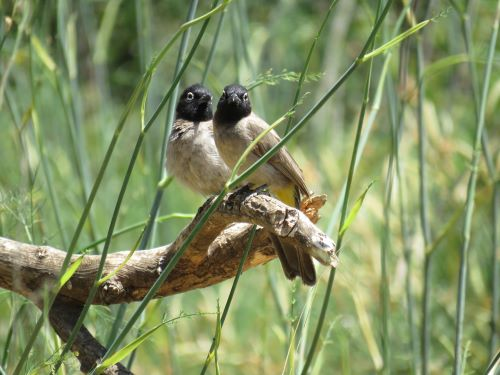




## Introduction to eBird and Jerusalem Data Observatory:

Last year, there were numerous reports from bird observers, including myself, indicating a decline in the number of migrating birds. Intrigued by this phenomenon, I embarked on an exploration to measure and understand it. To undertake this analysis, I required data, and therefore sought access to eBird data.

What is eBird? eBird is a globally recognized project that allows bird enthusiasts from around the world to submit their bird observations. It is essential to acknowledge that eBird is a citizen science project, meaning the data it encompasses may not be perfect, as it relies on contributions from both professional birders and non-experts.

One challenge I encountered was the presence of missing data, primarily from less frequently visited birding sites. Consequently, I had to make a decision regarding which data to select for comparing the current year with the previous one. After careful consideration, I chose to focus on the data from the Jerusalem Bird Observatory site.

I opted for this site for the following reasons:
- The Jerusalem Bird Observatory is a well-established observatory with a long history of tracking birds. Many of the observers there are experienced birders, thereby enhancing the reliability of the observations.
- Compared to other bird observation sites, it offers a substantial amount of available data.
- The observatory's geographic location, situated on a mountain, makes it an important visiting site for birds, especially smaller species.

Hence, I chose to utilize the data from the Jerusalem Bird Observatory site for my analysis.

Below are the provided links:

- eBird website: [https://ebird.org/home](https://ebird.org/home)
- Jerusalem Observatory checklists: [https://ebird.org/hotspot/L967976](https://ebird.org/hotspot/L967976)
- Jerusalem Observatory on Wikipedia: [https://en.wikipedia.org/wiki/Jerusalem_Bird_Observatory](https://en.wikipedia.org/wiki/Jerusalem_Bird_Observatory)
- Permission for access to eBird data: [https://ebird.org/data/download](https://ebird.org/data/download)


## Introduction to Classier-Drift Detection Algorithm (Lopez-Paz and Oquab, 2017)
I referred to the issue I introduced as a data drift measurement problem, where my objective is to compare bird observations or conduct a two-sample test. To tackle this, I investigated a method outlined in the article "Revisiting Classifier Two-Sample Tests" (link: https://arxiv.org/pdf/1610.06545.pdf).

The key idea of this method is to treat two-sample tests as a classification problem by following these steps:

- Combine the two different samples, each with its own label, into a single dataset.
- Split the data into training and test sets.
- Train a machine learning model on the training set.
- Calculate the accuracy on the test set.
- Calculate the p-value using the null distribution of the accuracy as described in the article.
- If the p-value is less than the significance value, we reject the null hypothesis that the samples came from the same distribution. In other words, we conclude that there is a drift in the data.

The main concept is that if both samples behave similarly, we would expect the accuracy on the test set to be approximately 0.5.  The article demonstrates that for a sufficiently large test-set size, the null distribution is $H_0: \text{Norm}(0.5, \frac{1}{4n})$, where $n$ is the test size.
Consequently, we can calculate the probability of obtaining this accuracy or higher under our assumption, which corresponds to the p-value.


## Providing Illustrations

In [144]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def calculate_p_value_for_normal_distribution(x, mu, sigma):
    """
    Calculates the p-value for a normal distribution given a sample mean 'x'.
    """
    z_score = (x - mu) / sigma
    p_value = 1 - norm.cdf(z_score)
    return p_value

def plot_accuracy_density_distribution_under_null_hypothesis(accuracy, n_test_size):
    mu = 0.5
    variance = 1 / (4 * n_test_size)  # according to the article.
    sigma = np.sqrt(variance)
    
    x = np.linspace(0, 1, 100)
    y = norm.pdf(x, mu, sigma)
    
    plt.plot(x, y, color='green', label=r'$\mathcal{N}(0.5, \frac{1}{4n})$')
    
    p_value = calculate_p_value_for_normal_distribution(accuracy, mu, sigma)
    lower_bound = accuracy
    upper_bound = 1
    x_fill = np.linspace(lower_bound, upper_bound, 100)
    y_fill = norm.pdf(x_fill, mu, sigma)
    
    plt.fill_between(x_fill, y_fill, color ='red', alpha=0.3, label=f'p-value is: {p_value:.4f}')
    plt.axvline(accuracy,linewidth=4, color='blue',linestyle ='--',label =f'Accuracy:{accuracy}')
    plt.legend()
    plt.xlabel('Accuracy')
    plt.ylabel('Density')
    plt.title(f'Accuracy Density Distribution under Null Hypothesis for n_test_size:{n_test_size}')
    plt.show()


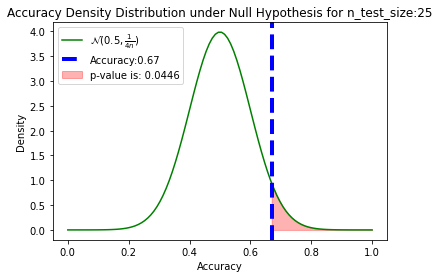

In [145]:
plot_accuracy_density_distribution_under_null_hypothesis(0.67, 25)

As you can see, as the accuracy deviates further from the expected value (which is 0.5 under the null distribution), the probability of obtaining this accuracy under the null assumption, which states that the two samples came from the same distribution, decreases rapidly.

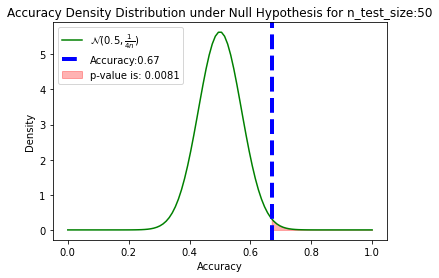

In [146]:
plot_accuracy_density_distribution_under_null_hypothesis(0.67, 50)

Moreover, as we increase the size of the test set, the distribution becomes narrower, increasing the probability of rejecting the null hypothesis when the accuracy is higher than 0.5.

## Utilizing Random Forest:

The Classifier-Drift Detection Algorithm allows us to use any machine learning classifier of our choice. However, I have opted to utilize a random forest for the following reasons:

- Random forest is known to be one of the strongest classical machine learning models, capable of detecting differences in patterns within the data. Despite its strength, it is relatively simpler compared to neural networks.
- Sklearn provides a convenient implementation of random forest, making it easy to use for our drift detection purposes.
- With sklearn, we can easily access the feature importance, which can provide insights into the criteria used by the random forest to detect the drift.

In [147]:
##### from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)


import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

<Figure size 640x640 with 0 Axes>

Read the daily data:

In [149]:
daily_data = pd.read_csv('daily_data_jerusalem_observations.csv',index_col=0)
daily_data.index = pd.to_datetime(daily_data.index)
all_birds = daily_data.columns.to_list()


### Applying the classifier-based drift method:

Sample selecting:

In [150]:
sample1 = daily_data['2021-04-03':'2022-04-02']
sample2 =daily_data['2022-04-03':'2023-04-02']

Combine the two different samples, each with its own label, into a single dataset:

In [151]:
sample1['Y'] = 0
sample2['Y'] = 1
Data = pd.concat([sample1,sample2])

Split the data into training and test sets.

In [152]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(Data[all_birds],Data['Y'] ,test_size = 0.35, random_state = 42)

Train a machine learning model on the training set and calculate the accuracy on the test set:

In [153]:
clf = RandomForestClassifier(max_depth = 7, random_state = 0)
clf.fit(X_train, Y_train)
clf.score(X_test,Y_test)

0.772972972972973

We have selected the conventional significance level of 0.05. Next, we proceed to calculate the p-value and generate the corresponding graph.

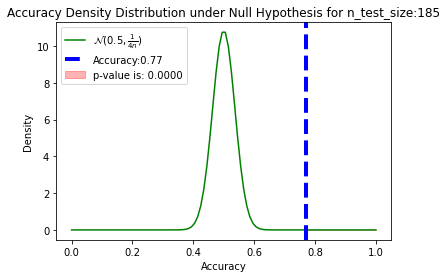

In [154]:
plot_accuracy_density_distribution_under_null_hypothesis(0.77,len(Y_test))

We obtained an extremely low p-value, indicating a significant difference between the samples. This suggests that there is a notable distinction between the observations from the current and previous years.

## Validation through Explainability:

The question arises: how can we place trust in these results? In other words, we are interested in understanding the features that the random forest model deemed significant when attempting to differentiate between the two samples. As we progress, we will examine the most important features (bird species) identified by the random forest model.

Next, we will plot graphs of these features and assess their meaningfulness and relevance.

Furthermore, we will generate perturbation graphs by systematically removing one feature at a time, starting from the most important and moving to the least important. This will allow us to observe the impact on the accuracy of the random forest classifier.

In [155]:
def get_feature_importance_cols(features_importances)->list:
    sorted_indices = np.argsort(features_importances)[::-1]
    return X_train.columns[sorted_indices].to_list()
    
#credit to stackoverflow:
#https://stackoverflow.com/questions/42128545/how-to-print-the-order-of-important-features-in-random-forest-regression-using-p
    

def get_least_important_cols(features_importances)->list:
    sorted_indices = np.argsort(features_importances)
    return X_train.columns[sorted_indices].to_list()


def plot_daily_bird_count_for_two_time_periods(
    bird_name: str,
    color_associated_with_the_bird: str,
    data: pd.DataFrame,
    baseline_period: slice,
    comparison_period: slice,
    center_date: dt.datetime
):
    sample1 = data.loc[baseline_period,bird_name]
    sample2 = data.loc[comparison_period,bird_name]
    s = pd.concat([sample1,sample2])
    plt.axvline(center_date,linewidth=4, color='red',linestyle ='--')
    s.plot(color = color_associated_with_the_bird,label=bird_name)
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Daily Count')
    plt.ylim(0)
    plt.title(f'Jerusalem Daily Count of {bird_name}')

In [156]:
most_important_columns = get_feature_importance_cols(clf.feature_importances_)
least_important_columns = get_least_important_cols(clf.feature_importances_)

In [157]:
print(most_important_columns[:10])


['Brambling', 'Eurasian Siskin', 'Common Chaffinch', 'Lesser Whitethroat', 'Common Myna', 'Eurasian Jackdaw', 'Rock Pigeon', 'Common Kingfisher', 'Eurasian Hoopoe', 'Monk Parakeet']


### We will plot a daily count comparison for the two time periods focusing on the bird species that are considered the most important features according to the random forest classifier.

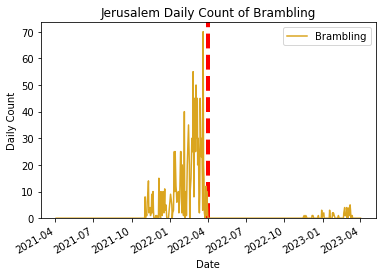

In [164]:
baseline_period = slice('2021-04-03','2022-04-02')
comparison_period = slice('2022-04-03','2023-04-02')
center_date = dt.datetime(2022, 4,2)

plot_daily_bird_count_for_two_time_periods('Brambling','goldenrod',
                                           daily_data,baseline_period,comparison_period,center_date)

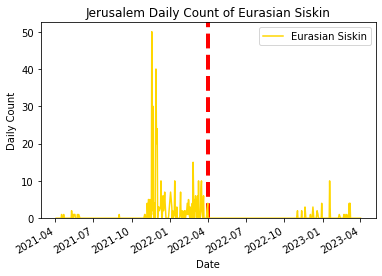

In [165]:
plot_daily_bird_count_for_two_time_periods('Eurasian Siskin','gold',
                                           daily_data,baseline_period,comparison_period,center_date)

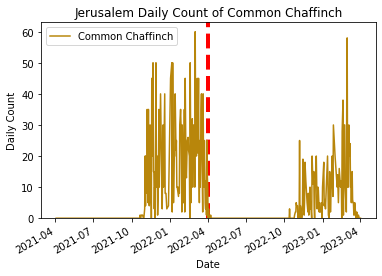

In [169]:
plot_daily_bird_count_for_two_time_periods('Common Chaffinch','darkgoldenrod',
                                           daily_data,baseline_period,comparison_period,center_date)

We observe that the first three features are highly informative. These birds share the characteristic of migrating to Israel during the winter season. This aligns with the reports from many observers who have noticed a decline in the number of wintering birds.

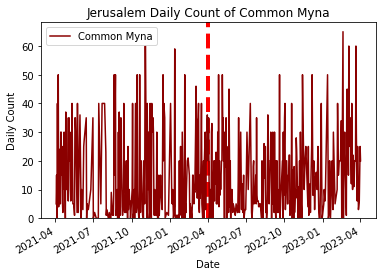

In [171]:
plot_daily_bird_count_for_two_time_periods('Common Myna','darkred',
                                           daily_data,baseline_period,comparison_period,center_date)

I have chosen to display the graph of the Common Myna because they are invasive species that pose a threat to other bird populations. While the population of certain bird species decreases, the population of invasive species like the Common Myna tends to increase. From the graph, we can observe a slight difference in the observations of Common Mynas, although it may not be highly noticeable. It is evident that in the last year, there has been an increase in the number of Common Myna sightings.

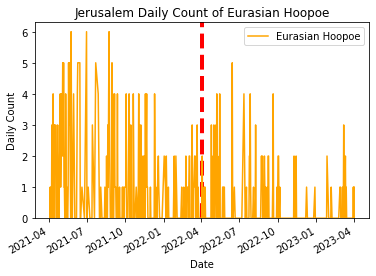

In [173]:
plot_daily_bird_count_for_two_time_periods('Eurasian Hoopoe','orange',
                                           daily_data,baseline_period,comparison_period,center_date)

The Eurasian Hoopoe is a relatively stable bird species in Israel, but its population has been decreasing, particularly due to the presence of the Common Myna. Therefore, it is logical that the random forest classifier identified the Eurasian Hoopoe as an important feature.

### Evaluate Feature Importance via Perturbation:

In [174]:
def calculate_peturbations(n,sorted_feature_importance, model,_X_train,_X_test,_Y_train,_Y_test):
    scores = []
    for  i in range(n+1):
        selected_features = sorted_feature_importance[i:]
        model.fit(_X_train[selected_features],_Y_train)
        scores.append(model.score(_X_test[selected_features],_Y_test))
    return scores
        
    

In [175]:
scores_for_most_important_features = calculate_peturbances(50,most_important_columns,clf,X_train,X_test,Y_train,Y_test)
score_for_least_important_features = calculate_peturbances(50,least_important_columns,clf,X_train,X_test,Y_train,Y_test)

Text(0, 0.5, 'Accuracy')

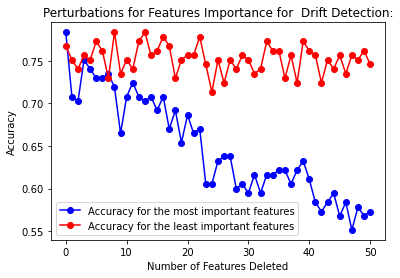

In [177]:
plt.plot(range(0,51), scores_for_most_important_features,'o-',color = 'blue',label='Accuracy for the most important features')
plt.plot(range(0,51), score_for_least_important_features,'o-',color = 'red',label='Accuracy for the least important features')
plt.title('Perturbations for Features Importance for  Drift Detection:')
plt.legend()
plt.xlabel('Number of Features Deleted')
plt.ylabel('Accuracy')

According to the perturbations, we can observe that the random forest focuses on the important features. When we delete these important features, the accuracy of the model decreases, unlike for the least important features. The previous bird graphs also provided evidence that the feature, based on which the random forest classified the difference between the two samples, aligns with our expectations and makes sense.

## Summary and Conclusion:

In conclusion, the Classier-Drift Detection Algorithm (Lopez-Paz and Oquab, 2017) has demonstrated good performance in detecting differences between the current and previous years. This claim is supported by the informative nature of the classifier features (Random Forest).Moreover,the results provide evidence that the observations made by people may not be a coincidence.

The observed differences may be attributed to several factors, including:
- Climate change
- The occurrence of a widespread flu disease last year, affecting many bird species
- Decrease in the amount of open areas

I chose to use this selected algorithm because, in my opinion, it is quite intuitive compared to other existing methods like Kernel Two-sample tests. Additionally, it allows us to understand the reasons behind the presence or absence of drift by examining the importance of features.

Thank you for reading!